In [ ]:
# import sys
# !{sys.executable} -m pip install tensorflow

In [33]:
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

# Get data

In [34]:
df = pd.read_csv('./../../labeledTweets/allLabeledTweets.csv')
df = df[['id', 'message', 'label']]
df.head()

,id,message,label
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0


In [35]:
df['label'].value_counts()

0    968
2    647
1    410
Name: label, dtype: int64

In [36]:
newLine ="\\n|\\r"
urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+((\.|\-)\d+)?'
mentions = '\B\@([\w\-]+)'
hashtag = '#'
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

df['clean_message'] = df['message']
df['clean_message'] = df['clean_message'].str.replace(newLine,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(urls,' URL ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(mentions,' MENTION ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(numbers,' NMBR ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(hashtag,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(whitespaces,' ',regex=True)
df['clean_message'] = df['clean_message'].str.replace(leadTrailWhitespace,'',regex=True)

df.head()

,id,message,label,clean_message
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...


# Train, validate split

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

In [38]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

id  message  clean_message
label data_type                             
0     train      823      823            823
      val        145      145            145
1     train      348      348            348
      val         62       62             62
2     train      550      550            550
      val         97       97             97

In [39]:
df.head()

,id,message,label,clean_message,data_type
0,1478404,Tiek vērtēti trīs potenciālie airBaltic invest...,0,Tiek vērtēti trīs potenciālie airBaltic invest...,train
1,1478695,Augulis: #airBaltic “potenciālie pircēji ir no...,0,Augulis: airBaltic “potenciālie pircēji ir no ...,val
2,1478812,airBaltic uzsāks lidojumus uz diviem jauniem g...,0,airBaltic uzsāks lidojumus uz diviem jauniem g...,train
3,1479295,Ministrs: Sarunas turpinās ar trīs potenciālaj...,0,Ministrs: Sarunas turpinās ar trīs potenciālaj...,train
4,1480097,@krisjaniskarins @Janis_Kazocins @EU2017EE Net...,0,MENTION MENTION MENTION Netrāpīs kādam AirBalt...,train


In [40]:
# df.to_csv('./tweets_cleaned.csv', index=False)

## Balance training data

In [41]:
df[df.data_type=='train']['label'].value_counts()

0    823
2    550
1    348
Name: label, dtype: int64

In [42]:
df_train = [df[df.data_type=='train'].clean_message, df[df.data_type=='train'].label]
df_train = pd.concat(df_train, axis=1, keys=["clean_message", "label"])

df_0 = df_train[df_train['label']==0]
df_1 = df_train[df_train['label']==1]
df_2 = df_train[df_train['label']==2]

df_0_downsampled = df_0.sample(df_1.shape[0], random_state=42)
df_2_downsampled = df_2.sample(df_1.shape[0], random_state=42)

df_train = pd.concat([df_0_downsampled, df_2_downsampled, df_1])

df_train['label'].value_counts()

0    348
1    348
2    348
Name: label, dtype: int64

In [43]:
# Shuffle rows
import sklearn

df_train = sklearn.utils.shuffle(df_train, random_state=0)

df_train.head()

,clean_message,label
700,Šodien norisinās SEB MTB maratons. Finišs MENT...,0
1911,MENTION Sveiks! Tas neattiecas uz mūsu ekspert...,1
505,"MENTION MENTION Starpcitu, Maxima tirgo labus ...",1
1471,Taisnība ir uzvarējusi! Martins Dukurs kļūst p...,1
1537,MENTION Спасибо за мнение.^el,0


# Tokenizer "lvBERT"

In [44]:
tokenizer = BertTokenizer.from_pretrained('./../lvbert_pytorch/', do_lower_case=False)

## Add emoji

In [45]:
import re

emoji_str = "😀 😃 😄 😁 😆 😅 😂 🤣 😊 😇 🙂 🙃 😉 😌 😍 🥰 😘 😗 😙 😚 😋 😛 😝 😜 🤪 🤨 🧐 🤓 😎 🤩 🥳 😏 😒 😞 😔 😟 😕 🙁 ☹️ 😣 😖 😫 😩 🥺 😢 😭 😤 😠 😡 🤬 🤯 😳 🥵 🥶 😱 😨 😰 😥 😓 🤗 🤔 🤭 🤫 🤥 😶 😐 😑 😬 🙄 😯 😦 😧 😮 😲 🥱 😴 🤤 😪 😵 🤐 🥴 🤢 🤮 🤧 😷 🤒 🤕 😺 😸 😹 😻 😼 😽 🙀 😿 😾 💩 👋 🤚 🖐 ✋ 🖖 👌 🤏 ✌️ 🤞 🤟 🤘 🤙 👈 👉 👆 🖕 👇 ☝️ 👍 👎 ✊ 👊 🤛 🤜 👏 🙌 👐 🤲 🤝 🙏'👋🏻 🤚🏻 🖐🏻 ✋🏻 🖖🏻 👌🏻 🤏🏻 ✌🏻 🤞🏻 🤟🏻 🤘🏻 🤙🏻 👈🏻 👉🏻 👆🏻 🖕🏻 👇🏻 ☝🏻 👍🏻 👎🏻 ✊🏻 👊🏻 🤛🏻 🤜🏻 👏🏻 🙌🏻 👐🏻 🤲🏻 🙏🏻 👋🏼 🤚🏼 🖐🏼 ✋🏼 🖖🏼 👌🏼 🤏🏼 ✌🏼 🤞🏼 🤟🏼 🤘🏼 🤙🏼 👈🏼 👉🏼 👆🏼 🖕🏼 👇🏼 ☝🏼 👍🏼 👎🏼 ✊🏼 👊🏼 🤛🏼 🤜🏼 👏🏼 🙌🏼 👐🏼 🤲🏼 🙏🏼 👋🏽 🤚🏽 🖐🏽 ✋🏽 🖖🏽 👌🏽 🤏🏽 ✌🏽 🤞🏽 🤟🏽 🤘🏽 🤙🏽 👈🏽 👉🏽 👆🏽 🖕🏽 👇🏽 ☝🏽 👍🏽 👎🏽 ✊🏽 👊🏽 🤛🏽 🤜🏽 👏🏽 🙌🏽 👐🏽 🤲🏽 🙏👋🏾 🤚🏾 🖐🏾 ✋🏾 🖖🏾 👌🏾 🤏🏾 ✌🏾 🤞🏾 🤟🏾 🤘🏾 🤙🏾 👈🏾 👉🏾 👆🏾 🖕🏾 👇🏾 ☝🏾 👍🏾 👎🏾 ✊🏾 👊🏾 🤛🏾 🤜🏾 👏🏾 🙌🏾 👐🏾 🤲🏾 🙏 👋🏿 🤚🏿 🖐🏿 ✋🏿 🖖🏿 👌🏿 🤏🏿 ✌🏿 🤞🏿 🤟🏿 🤘🏿 🤙🏿 👈🏿 👉🏿 👆🏿 🖕🏿 👇🏿 ☝🏿 👍🏿 👎🏿 ✊🏿 👊🏿 🤛🏿 🤜🏿 👏🏿 🙌🏿 👐🏿 🤲🏿 🙏🏿 ❤️ 🧡 💛 💚 💙 💜 🖤 🤍 🤎 💔 ❣️ 💕 💞 💓 💗 💖 💘 💝 💟 💑🏻 💑🏼 💑🏽 💑🏾 💑🏿 💏🏻 💏🏼 💏🏽 💏🏾 💏🏿 👨🏻‍❤️‍👨🏻 👨🏻‍❤️‍👨🏼 👨🏻‍❤️‍👨🏽 👨🏻‍❤️‍👨🏾 👨🏻‍❤️‍👨🏿 👨🏼‍❤️‍👨🏻 👨🏼‍❤️‍👨🏼 👨🏼‍❤️‍👨🏽 👨🏼‍❤️‍👨🏾 👨🏼‍❤️‍👨🏿 👨🏽‍❤️‍👨🏻 👨🏽‍❤️‍👨🏼 👨🏽‍❤️‍👨🏽 👨🏽‍❤️‍👨🏾 👨🏽‍❤️‍👨🏿 👨🏾‍❤️‍👨🏻 👨🏾‍❤️‍👨🏼 👨🏾‍❤️‍👨🏽 👨🏾‍❤️‍👨🏾 👨🏾‍❤️‍👨🏿 👨🏿‍❤️‍👨🏻 👨🏿‍❤️‍👨🏼 👨🏿‍❤️‍👨🏽 👨🏿‍❤️‍👨🏾 👨🏿‍❤️‍👨🏿 👩🏻‍❤️‍👨🏻 👩🏻‍❤️‍👨🏼 👩🏻‍❤️‍👨🏽 👩🏻‍❤️‍👨🏾 👩🏻‍❤️‍👨🏿 👩🏻‍❤️‍👩🏻 👩🏻‍❤️‍👩🏼 👩🏻‍❤️‍👩🏽 👩🏻‍❤️‍👩🏾 👩🏻‍❤️‍👩🏿 👩🏼‍❤️‍👨🏻 👩🏼‍❤️‍👨🏼 👩🏼‍❤️‍👨🏽 👩🏼‍❤️‍👨🏾 👩🏼‍❤️‍👨🏿 👩🏼‍❤️‍👩🏻 👩🏼‍❤️‍👩🏼 👩🏼‍❤️‍👩🏽 👩🏼‍❤️‍👩🏾 👩🏼‍❤️‍👩🏿 👩🏽‍❤️‍👨🏻 👩🏽‍❤️‍👨🏼 👩🏽‍❤️‍👨🏽 👩🏽‍❤️‍👨🏾 👩🏽‍❤️‍👨🏿 👩🏽‍❤️‍👩🏻 👩🏽‍❤️‍👩🏼 👩🏽‍❤️‍👩🏽 👩🏽‍❤️‍👩🏾 👩🏽‍❤️‍👩🏿 👩🏾‍❤️‍👨🏻 👩🏾‍❤️‍👨🏼 👩🏾‍❤️‍👨🏽 👩🏾‍❤️‍👨🏾 👩🏾‍❤️‍👨🏿 👩🏾‍❤️‍👩🏻 👩🏾‍❤️‍👩🏼 👩🏾‍❤️‍👩🏽 👩🏾‍❤️‍👩🏾 👩🏾‍❤️‍👩🏿 👩🏿‍❤️‍👨🏻 👩🏿‍❤️‍👨🏼 👩🏿‍❤️‍👨🏽 👩🏿‍❤️‍👨🏾 👩🏿‍❤️‍👨🏿 👩🏿‍❤️‍👩🏻 👩🏿‍❤️‍👩🏼 👩🏿‍❤️‍👩🏽 👩🏿‍❤️‍👩🏾 👩🏿‍❤️‍👩🏿 🧑🏻‍❤️‍🧑🏼 🧑🏻‍❤️‍🧑🏽 🧑🏻‍❤️‍🧑🏾 🧑🏻‍❤️‍🧑🏿 🧑🏼‍❤️‍🧑🏻 🧑🏼‍❤️‍🧑🏽 🧑🏼‍❤️‍🧑🏾 🧑🏼‍❤️‍🧑🏿 🧑🏽‍❤️‍🧑🏻 🧑🏽‍❤️‍🧑🏼 🧑🏽‍❤️‍🧑🏾 🧑🏽‍❤️‍🧑🏿 🧑🏾‍❤️‍🧑🏻 🧑🏾‍❤️‍🧑🏼 🧑🏾‍❤️‍🧑🏽 🧑🏾‍❤️‍🧑🏿 🧑🏿‍❤️‍🧑🏻 🧑🏿‍❤️‍🧑🏼 🧑🏿‍❤️‍🧑🏽 🧑🏿‍❤️‍🧑🏾 👨🏻‍❤️‍💋‍👨🏻 👨🏻‍❤️‍💋‍👨🏼 👨🏻‍❤️‍💋‍👨🏽 👨🏻‍❤️‍💋‍👨🏾 👨🏻‍❤️‍💋‍👨🏿 👨🏼‍❤️‍💋‍👨🏻 👨🏼‍❤️‍💋‍👨🏼 👨🏼‍❤️‍💋‍👨🏽 👨🏼‍❤️‍💋‍👨🏾 👨🏼‍❤️‍💋‍👨🏿 👨🏽‍❤️‍💋‍👨🏻 👨🏽‍❤️‍💋‍👨🏼 👨🏽‍❤️‍💋‍👨🏽 👨🏽‍❤️‍💋‍👨🏾 👨🏽‍❤️‍💋‍👨🏿 👨🏾‍❤️‍💋‍👨🏻 👨🏾‍❤️‍💋‍👨🏼 👨🏾‍❤️‍💋‍👨🏽 👨🏾‍❤️‍💋‍👨🏾 👨🏾‍❤️‍💋‍👨🏿 👨🏿‍❤️‍💋‍👨🏻 👨🏿‍❤️‍💋‍👨🏼 👨🏿‍❤️‍💋‍👨🏽 👨🏿‍❤️‍💋‍👨🏾 👨🏿‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👨🏻 👩🏻‍❤️‍💋‍👨🏼 👩🏻‍❤️‍💋‍👨🏽 👩🏻‍❤️‍💋‍👨🏾 👩🏻‍❤️‍💋‍👨🏿 👩🏻‍❤️‍💋‍👩🏻 👩🏻‍❤️‍💋‍👩🏼 👩🏻‍❤️‍💋‍👩🏽 👩🏻‍❤️‍💋‍👩🏾 👩🏻‍❤️‍💋‍👩🏿 👩🏼‍❤️‍💋‍👨🏻 👩🏼‍❤️‍💋‍👨🏼 👩🏼‍❤️‍💋‍👨🏽 👩🏼‍❤️‍💋‍👨🏾 👩🏼‍❤️‍💋‍👨🏿 👩🏼‍❤️‍💋‍👩🏻 👩🏼‍❤️‍💋‍👩🏼 👩🏼‍❤️‍💋‍👩🏽 👩🏼‍❤️‍💋‍👩🏾 👩🏼‍❤️‍💋‍👩🏿 👩🏽‍❤️‍💋‍👨🏻 👩🏽‍❤️‍💋‍👨🏼 👩🏽‍❤️‍💋‍👨🏽 👩🏽‍❤️‍💋‍👨🏾 👩🏽‍❤️‍💋‍👨🏿 👩🏽‍❤️‍💋‍👩🏻 👩🏽‍❤️‍💋‍👩🏼 👩🏽‍❤️‍💋‍👩🏽 👩🏽‍❤️‍💋‍👩🏾 👩🏽‍❤️‍💋‍👩🏿 👩🏾‍❤️‍💋‍👨🏻 👩🏾‍❤️‍💋‍👨🏼 👩🏾‍❤️‍💋‍👨🏽 👩🏾‍❤️‍💋‍👨🏾 👩🏾‍❤️‍💋‍👨🏿 👩🏾‍❤️‍💋‍👩🏻 👩🏾‍❤️‍💋‍👩🏼 👩🏾‍❤️‍💋‍👩🏽 👩🏾‍❤️‍💋‍👩🏾 👩🏾‍❤️‍💋‍👩🏿 👩🏿‍❤️‍💋‍👨🏻 👩🏿‍❤️‍💋‍👨🏼 👩🏿‍❤️‍💋‍👨🏽 👩🏿‍❤️‍💋‍👨🏾 👩🏿‍❤️‍💋‍👨🏿 👩🏿‍❤️‍💋‍👩🏻 👩🏿‍❤️‍💋‍👩🏼 👩🏿‍❤️‍💋‍👩🏽 👩🏿‍❤️‍💋‍👩🏾 👩🏿‍❤️‍💋‍👩🏿 🧑🏻‍❤️‍💋‍🧑🏼 🧑🏻‍❤️‍💋‍🧑🏽 🧑🏻‍❤️‍💋‍🧑🏾 🧑🏻‍❤️‍💋‍🧑🏿 🧑🏼‍❤️‍💋‍🧑🏻 🧑🏼‍❤️‍💋‍🧑🏽 🧑🏼‍❤️‍💋‍🧑🏾 🧑🏼‍❤️‍💋‍🧑🏿 🧑🏽‍❤️‍💋‍🧑🏻 🧑🏽‍❤️‍💋‍🧑🏼 🧑🏽‍❤️‍💋‍🧑🏾 🧑🏽‍❤️‍💋‍🧑🏿 🧑🏾‍❤️‍💋‍🧑🏻 🧑🏾‍❤️‍💋‍🧑🏼 🧑🏾‍❤️‍💋‍🧑🏽 🧑🏾‍❤️‍💋‍🧑🏿 🧑🏿‍❤️‍💋‍🧑🏻 🧑🏿‍❤️‍💋‍🧑🏼 🧑🏿‍❤️‍💋‍🧑🏽 🧑🏿‍❤️‍💋‍🧑🏾 👭 🧑‍🤝‍🧑 👬 👫 👩‍❤️‍👩 💑 👨‍❤️‍👨 👩‍❤️‍👨 👩‍❤️‍💋‍👩 💏 👨‍❤️‍💋‍👨 👩‍❤️‍💋‍👨 👪 👨‍👩‍👦 👨‍👩‍👧 👨‍👩‍👧‍👦 👨‍👩‍👦‍👦 👨‍👩‍👧‍👧 👨‍👨‍👦 👨‍👨‍👧 👨‍👨‍👧‍👦 👨‍👨‍👦‍👦 👨‍👨‍👧‍👧 👩‍👩‍👦 👩‍👩‍👧 👩‍👩‍👧‍👦 👩‍👩‍👦‍👦 👩‍👩‍👧‍👧 👨‍👦 👨‍👦‍👦 👨‍👧 👨‍👧‍👦 👨‍👧‍👧 👩‍👦 👩‍👦‍👦 👩‍👧 👩‍👧‍👦 👩‍ 👧‍👧 💋"
emoji_list = emoji_str.split(' ')
emoji_regex = '|'.join(emoji_list)

In [46]:
all_emoji = []
for message in df.clean_message:
    foundEmoji = re.findall(emoji_regex, message)
    for emoji in foundEmoji:
        all_emoji.append(emoji)

print(len(all_emoji))

107


In [47]:
import collections

counter=collections.Counter(all_emoji)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]

[('😂', 12), ('🤔', 9), ('😁', 9), ('👍', 7), ('👉', 6), ('🙄', 6), ('😀', 5), ('😉', 5), ('😎', 5), ('😊', 4), ('🤗', 3), ('😅', 3), ('👏', 3), ('❤️', 3), ('😥', 2), ('😵', 2), ('😍', 2), ('😆', 2), ('🤘', 2), ('🤬', 2), ('🙂', 2), ('😖', 1), ('🤥', 1), ('☝️', 1), ('🙁', 1), ('🤣', 1), ('😳', 1), ('🙌', 1), ('👌', 1), ('🤓', 1), ('😌', 1), ('🤢', 1), ('👇', 1), ('😜', 1)]


In [16]:
tokenizer.add_tokens(most_common_values, special_tokens=True)

34

In [17]:
#other UNK tokens

unk_tokens = []
for message in df.clean_message.values:
    list_of_space_separated_pieces = message.strip().split()
    ids = [tokenizer(piece, add_special_tokens=False)["input_ids"] for piece in list_of_space_separated_pieces]
    unk_indices = [i for i, encoded in enumerate(ids) if tokenizer.unk_token_id in encoded]
    unknown_strings = [piece for i, piece in enumerate(list_of_space_separated_pieces) if i in unk_indices]
    for unk_str in unknown_strings:
        unk_tokens.append(unk_str)

In [18]:
import collections

counter=collections.Counter(unk_tokens)
print(counter.most_common(100))

most_common_values= [word for word, word_count in counter.most_common(100)]

[('^vi', 34), ('^ai', 30), ('^el', 22), ('(', 19), ('^il', 19), ('–', 17), ('^la', 17), ('^na', 17), ('€', 15), ('^ma', 15), ('^ri', 13), ('+', 11), ('X', 11), (':(', 8), ('Ļoti', 8), ('^ju', 8), ('🇱🇻', 7), ('&amp;', 6), ('MAXIMA', 5), ('🎄', 5), ('€.', 4), ('^nn', 4), ('|', 3), ('(vai', 3), ('ibankā', 3), ('Žēl,', 3), ('You', 3), ('не', 3), ('за', 3), ('в', 3), ('▶️', 3), ('uzs…', 2), ('YL-CSK.', 2), ('(un', 2), ('nav…', 2), ('(pat', 2), ('=', 2), ('ļoooti', 2), ('(kaut', 2), ('XX', 2), ('“Valmiera/ORDO”', 2), ('~', 2), ('🇷🇺', 2), ('(@', 2), ('*', 2), ('🤷\u200d♀️', 2), ('✨', 2), ('(FKTK)', 2), ('(VDD)', 2), ('(sauksim', 2), ('Если', 2), ('Yes,', 2), ('(+', 2), ('нас', 2), ('Добрый', 2), ('день!', 2), ('Pārbaudīsim.^la', 2), ('iOS', 2), ('“Maxima', 2), ('[..]', 2), ('XXX', 2), ('📲', 2), ('“potenciālie', 1), ('pasaules”', 1), ('(maijā),', 1), ('“', 1), ('slīpie”', 1), ('*FB', 1), ('konkursu*', 1), ('Pa…', 1), ('liepajatravel…', 1), ('✈️Izdevīgas', 1), ('Qatar', 1), ('QR', 1), ('(Rīgā:', 

### Find max length for tokenizer

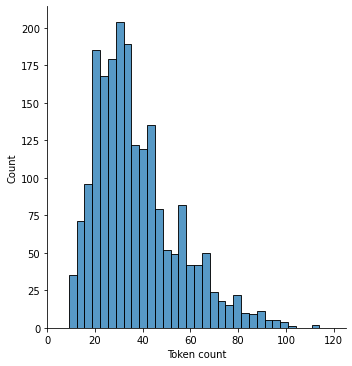

In [20]:
token_lens = []
for txt in list(df.clean_message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 125])
plt.xlabel('Token count')
plt.show()

In [21]:
max_length = 120

### Encode messages

In [22]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train["clean_message"].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].clean_message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=max_length, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df_train.label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [23]:
len(dataset_train), len(dataset_val)

(1044, 304)

In [23]:
# torch.save(dataset_train, './datasetsLowercase/dataset_train.pt')
# torch.save(dataset_val, './datasetsLowercase/dataset_val.pt')

In [24]:
# dataset_train = torch.load('./datasetsLowercase/dataset_train.pt')
# dataset_val = torch.load('./datasetsLowercase/dataset_val.pt')

In [25]:
# len(dataset_train), len(dataset_val)

# Model "lvBERT"

In [24]:
model = BertForSequenceClassification.from_pretrained('./../lvbert_pytorch/',
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at ./../lvbert_pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint

In [25]:
model.resize_token_embeddings(len(tokenizer))

Embedding(32038, 768)

In [26]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [27]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [28]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [29]:
# Function to measure weighted F1

from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [30]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
model.to(device)
print(device)

cpu


In [31]:
# Function to evaluate model. Returns average validation loss, predictions, true values

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    progress_bar = tqdm(dataloader_val, desc='Validating:', leave=False, disable=False)
    for batch in progress_bar:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

# Train

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'modelsEmoji/finetuned_lvBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    preds_flat = np.argmax(predictions, axis=1).flatten()
    
    print('Classification report:')
    print(classification_report(true_vals, preds_flat))
    print('Confusion matrix:')
    print(pd.DataFrame(confusion_matrix(true_vals, preds_flat),
            index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
            columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]))
    print('--------------------------------------------------------------')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9977031873934197


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.8640809476375579
F1 Score (Weighted): 0.645687694897557
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       145
           1       0.51      0.68      0.58        62
           2       0.61      0.63      0.62        97

    accuracy                           0.64       304
   macro avg       0.63      0.65      0.63       304
weighted avg       0.66      0.64      0.65       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         92       27       26
       positive         7       42       13
       negative        22       14       61
--------------------------------------------------------------


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7618873841834791


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7788904011249542
F1 Score (Weighted): 0.6730091598042726
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.59      0.68       145
           1       0.53      0.84      0.65        62
           2       0.67      0.68      0.67        97

    accuracy                           0.67       304
   macro avg       0.67      0.70      0.67       304
weighted avg       0.70      0.67      0.67       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         86       33       26
       positive         3       52        7
       negative        18       13       66
--------------------------------------------------------------


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6298192224719308


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7755580723285675
F1 Score (Weighted): 0.6577505750985712
Classification report:
              precision    recall  f1-score   support

           0       0.78      0.56      0.65       145
           1       0.51      0.90      0.65        62
           2       0.69      0.65      0.67        97

    accuracy                           0.66       304
   macro avg       0.66      0.70      0.66       304
weighted avg       0.70      0.66      0.66       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         81       40       24
       positive         2       56        4
       negative        21       13       63
--------------------------------------------------------------


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5277330441908403


Validating::   0%|          | 0/10 [00:00<?, ?it/s]

Validation loss: 0.7529236853122712
F1 Score (Weighted): 0.6732369406932607
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       145
           1       0.55      0.92      0.69        62
           2       0.70      0.59      0.64        97

    accuracy                           0.67       304
   macro avg       0.67      0.71      0.67       304
weighted avg       0.70      0.67      0.67       304

Confusion matrix:
                predicted                  
                  neutral positive negative
actual neutral         91       33       21
       positive         2       57        3
       negative        26       14       57
--------------------------------------------------------------


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]

# Evaluate

In [ ]:
model.load_state_dict(torch.load('modelsEmoji/finetuned_BERT_epoch_X.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
preds_flat = np.argmax(predictions, axis=1).flatten()

In [ ]:
classification_report(true_vals, preds_flat)

In [ ]:
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']]